# Iris dataset classification with support vector machine

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelBinarizer
import pyprind

import sys
sys.path.append('../')
from networks import *
from optimizers import *

/Users/kirill/anaconda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [2]:
iris = load_iris()
X = iris.data[:, :2]
y = iris.target
# standardize
mean = X.mean(axis=0)
std = X.std(axis=0)
X = (X - mean) / std
one_hot_y = np.array(LabelBinarizer().fit_transform(y).T)

In [15]:
cg = ComputationalGraph()
x_in = cg.constant(name="X.T")
W = cg.variable("W", 0.01 * np.random.randn(3, X.shape[1]))
svm_output = cg.matrix_multiply(W, x_in)
svm_output.name = "svm_output"

y_train = cg.constant(name="one_hot_y")
loss = hinge(cg, svm_output, y_train, X.shape[1], "loss_hinge")

ctx = SimulationContext()        

sgd = MomentumSgdOptimizer(learning_rate=0.01)
batch_size=256
epochs = 1000
bar = pyprind.ProgBar(epochs, bar_char='█', width=60, track_time=True, stream=1)
for epoch in range(0, epochs):
    indexes = np.arange(0, len(X))
    np.random.shuffle(indexes)
    train_x = X[indexes]
    train_y = one_hot_y[:, indexes]    
    for batch in range(0, len(train_x), batch_size):
        batch_x = train_x[batch:batch + batch_size]
        batch_y = train_y[:, batch:batch + batch_size]
        sgd.minimize(ctx, cg, {x_in: batch_x.T, y_train: batch_y})    
    bar.update(item_id = "loss = {0:.2f}".format(ctx[loss].value))

ctx.forward(cg, {x_in: X.T, y_train: 1})
y_pred = np.argmax(ctx[svm_output].value, axis=0)

accuracy = np.sum(y_pred == y) / len(y)
accuracy

0%                                                        100%
[████████████████████████████████████████████████████████████] | ETA: 00:00:00 | Item ID: loss = 52.32
Total time elapsed: 00:00:00


0.77333333333333332

/Users/kirill/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


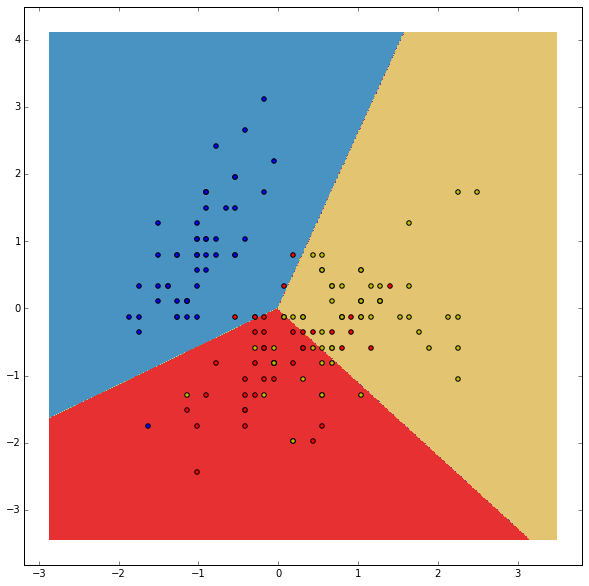

In [17]:
colors = "bry"
fig = plt.figure()
   
h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

mps = np.c_[xx.ravel(), yy.ravel()]
ctx.forward(cg, {x_in: mps.T, y_train: 1})
Z = np.argmax(ctx[svm_output].value, axis=0)
# Put the result into a color plot
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

for i, color in zip(np.unique(iris.target), colors):
    idx = np.where(y == i)
    plt.scatter(X[y == i, 0], X[y == i, 1], c=color, label=iris.target_names[i], cmap=plt.cm.Paired)

plt.axis('tight')
fig.set_size_inches(10, 10)